# 3.14 正向传播、反向传播和计算图
前面几节里我们使用了小批量随机梯度下降的优化算法来训练模型。在实现中，我们只提供了模型的正向传播（forward propagation）的计算，即对输入计算模型输出，然后通过autograd模块来调用系统自动生成的backward函数计算梯度。基于反向传播（back-propagation）算法的自动求梯度极大简化了深度学习模型训练算法的实现。本节我们将使用数学和计算图（computational graph）两个方式来描述正向传播和反向传播。具体来说，我们将以带$L2$范数正则化的含单隐藏层的多层感知机为样例模型解释正向传播和反向传播。

## 3.14.1 正向传播
正向传播是指对神经网络沿着从输入层到输出层的顺序，依次计算并存储模型的中间变量（包括输出）。为简单起见，假设输入是一个特征为$x\in\mathbb{R}^d$的样本，且不考虑偏差项，那么中间变量

$$z=\boldsymbol{W}^{(1)}x$$

其中$\boldsymbol{W}^{(1)}\in\mathbb{R}^{h \times d}$是隐藏层的权重参数。把中间变量$z\in \mathbb{R}^h$输入按元素运算的激活函数$\phi$后，将得到向量长度为 h 的隐藏层变量

$$h=\phi(z)$$

隐藏层变量 h 也是一个中间变量。假设输出层参数只有权重$\boldsymbol{W}^{(2)} \in \mathbb{R}^{q \times h}$，可以得到向量长度为$q$的输出层变量

$$\boldsymbol{o} = \boldsymbol{W}^{(2)} \boldsymbol{h}.$$

假设损失函数为$\ell$，且样本标签为$y$，可以计算出单个数据样本的损失项

$$L = \ell(\boldsymbol{o}, y).$$

根据$L_2$范数正则化的定义，给定超参数$\lambda$，正则化项即

$$s = \frac{\lambda}{2} \left(\|\boldsymbol{W}^{(1)}\|_F^2 + \|\boldsymbol{W}^{(2)}\|_F^2\right),$$

其中矩阵的Frobenius范数等价于将矩阵变平为向量后计算$L_2$范数。最终，模型在给定的数据样本上带正则化的损失为

$$J = L + s.$$

我们将$J$称为有关给定数据样本的目标函数，并在以下的讨论中简称目标函数。

## 3.14.2 正向传播的计算图
我们通常绘制计算图来可视化运算符和变量在计算中的依赖关系。下图绘制了本节中样例模型正向传播的计算图，其中左下角是输入，右上角是输出。可以看到，图中箭头方向大多是向右和向上，其中方框代表变量，圆圈代表运算符，箭头表示从输入到输出之间的依赖关系。
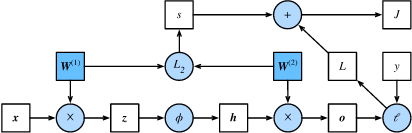

## 3.14.3 反向传播
反向传播指的是计算神经网络参数梯度的方法，总的来说，反向传播依据微积分中的链式法则，沿着从输出层到输入层的顺序，依次计算并存储目标函数有关神经网络各层的中间变量以及参数的梯度。对输入或输出$X,Y,Z$为任意形状张量的函数$Y=f(X)$和$Z=g(Y)$，通过链式法则，我们有

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right),$$

其中$\text{prod}$运算符将根据两个输入的形状，在必要的操作（如转置和互换输入位置）后对两个输入做乘法。

在上面的样例模型中，它的参数是$W^{(1)}$和$W^{(2)}$，因此反向传播的目标是计算$\partial J/\partial \boldsymbol{W}^{(1)}$和$\partial J/\partial \boldsymbol{W}^{(2)}$。我们将应用链式法则依次计算各中间变量和参数的梯度，其计算次序与前向传播中相应中间变量的计算次序恰恰相反。首先，分别计算目标函数$J=L+s$有关损失项$L$和正则项$s$的梯度

$$\frac{\partial J}{\partial L} = 1, \quad \frac{\partial J}{\partial s} = 1.$$

其次，依据链式法则计算目标函数有关输出层变量的梯度$\partial J/\partial \boldsymbol{o} \in \mathbb{R}^q$：

$$
\frac{\partial J}{\partial \boldsymbol{o}}
= \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \boldsymbol{o}}\right)
= \frac{\partial L}{\partial \boldsymbol{o}}.
$$

接下来，计算正则项有关两个参数的梯度：

$$\frac{\partial s}{\partial \boldsymbol{W}^{(1)}} = \lambda \boldsymbol{W}^{(1)},\quad\frac{\partial s}{\partial \boldsymbol{W}^{(2)}} = \lambda \boldsymbol{W}^{(2)}.$$

现在，我们可以计算最靠近输出层的模型参数的梯度$\partial J/\partial \boldsymbol{W}^{(2)} \in \mathbb{R}^{q \times h}$。依据链式法则，得到

$$
\frac{\partial J}{\partial \boldsymbol{W}^{(2)}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{o}}, \frac{\partial \boldsymbol{o}}{\partial \boldsymbol{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \boldsymbol{W}^{(2)}}\right)
= \frac{\partial J}{\partial \boldsymbol{o}} \boldsymbol{h}^\top + \lambda \boldsymbol{W}^{(2)}.
$$

沿着输出层向隐藏层继续反向传播，隐藏层变量的梯度$\partial J/\partial \boldsymbol{h} \in \mathbb{R}^h$可以这样计算：

$$
\frac{\partial J}{\partial \boldsymbol{h}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{o}}, \frac{\partial \boldsymbol{o}}{\partial \boldsymbol{h}}\right)
= {\boldsymbol{W}^{(2)}}^\top \frac{\partial J}{\partial \boldsymbol{o}}.
$$


由于激活函数$\phi$是按元素运算的，中间变量$\boldsymbol{z}$的梯度$\partial J/\partial \boldsymbol{z} \in \mathbb{R}^h$的计算需要使用按元素乘法符$\odot$：

$$
\frac{\partial J}{\partial \boldsymbol{z}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{h}}, \frac{\partial \boldsymbol{h}}{\partial \boldsymbol{z}}\right)
= \frac{\partial J}{\partial \boldsymbol{h}} \odot \phi'\left(\boldsymbol{z}\right).
$$

最终，我们可以得到最靠近输入层的模型参数的梯度$\partial J/\partial \boldsymbol{W}^{(1)} \in \mathbb{R}^{h \times d}$。依据链式法则，得到

$$
\frac{\partial J}{\partial \boldsymbol{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{z}}, \frac{\partial \boldsymbol{z}}{\partial \boldsymbol{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \boldsymbol{W}^{(1)}}\right)
= \frac{\partial J}{\partial \boldsymbol{z}} \boldsymbol{x}^\top + \lambda \boldsymbol{W}^{(1)}.
$$

## 3.14.4 训练深度学习模型
在训练深度学习模型时，正向传播和反向传播之间相互依赖。下面我们仍然以本节中的样例模型分别阐述它们之间的依赖关系。

一方面，正向传播的计算可能依赖于模型参数的当前值，而这些模型参数是在反向传播的梯度计算后通过优化算法迭代的。例如，计算正则化项$s = (\lambda/2) \left(\|\boldsymbol{W}^{(1)}\|_F^2 + \|\boldsymbol{W}^{(2)}\|_F^2\right)$依赖模型参数$\boldsymbol{W}^{(1)}$和$\boldsymbol{W}^{(2)}$的当前值，而这些当前值是优化算法最近一次根据反向传播算出梯度后迭代得到的。

另一方面，反向传播的梯度计算可能依赖于各变量的当前值，而这些变量的当前值是通过正向传播计算得到的。举例来说，参数梯度$\partial J/\partial \boldsymbol{W}^{(2)} = (\partial J / \partial \boldsymbol{o}) \boldsymbol{h}^\top + \lambda \boldsymbol{W}^{(2)}$的计算需要依赖隐藏层变量的当前值$\boldsymbol{h}$。这个当前值是通过从输入层到输出层的正向传播计算并存储得到的。

因此，在模型参数初始化完成后，我们交替地进行正向传播和反向传播，并根据反向传播计算的梯度迭代模型参数。既然我们在反向传播中使用了正向传播中计算得到的中间变量来避免重复计算，那么这个复用也导致正向传播结束后不能立即释放中间变量内存。这也是训练要比预测占用更多内存的一个重要原因。另外需要指出的是，这些中间变量的个数大体上与网络层数线性相关，每个变量的大小跟批量大小和输入个数也是线性相关的，它们是导致较深的神经网络使用较大批量训练时更容易超内存的主要原因。

## 小结
* 正向传播沿着从输入层到输出层的顺序，依次计算并存储神经网络的中间变量。
* 反向传播沿着从输出层到输入层的顺序，依次计算并存储神经网络中间变量和参数的梯度。
* 在训练深度学习模型时，正向传播和反向传播相互依赖。